In [2]:
from sys import version_info
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from skimage.data import page
from skimage.filters import threshold_sauvola
print('Python version: ' + str(version_info[:3]))
print('OpenCV version: ' + cv2.__version__)
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
            
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2.imwrite("output_files/biggest_component.png", img2)
    return img2

def inverted(imagem):
    imagem = (255-imagem)
    return imagem
    
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imwrite('output_files/connected_components.png', labeled_img)

Python version: (3, 7, 3)
OpenCV version: 4.1.0


In [3]:
#Read image, and perform binarization using Otsu algorithm
img = cv2.imread('input_files/test7.jpg')  #Afbeelding waar je alles op uitvoert
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Perform OTSU binarization
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#Show  and save image
cv2.imwrite('output_files/otsu.png',thresh)
#Find connected components of image
output_components = cv2.connectedComponentsWithStats(cv2.bitwise_not(thresh))
# The first cell is the number of labels
num_labels = output_components[0]
# The second cell is the label matrix
labels = output_components[1]
# The third cell is the stat matrix
stats = output_components[2]
# The fourth cell is the centroid matrix
centroids = output_components[3]
#Show the components of the image
imshow_components(labels)

In [4]:
#Get the biggest components, the dead sea scroll.
largest_component = undesired_objects(cv2.bitwise_not(thresh))
#Convert to right type
largest_component = largest_component.astype('uint8')
#Save file for debugging purposes. 
cv2.imwrite('output_files/is_dit_het_nou.png', largest_component)

True

In [5]:
largest_component_copy = largest_component
contours, hierarchy = cv2.findContours(largest_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

print(bounding_boxes)
x = bounding_boxes[0][0]
y = bounding_boxes[0][1]
width = bounding_boxes[0][2]
height = bounding_boxes[0][3]
#Crop the image to get only the scroll
crop_img = largest_component_copy[y:y+height, x:x+width]
cv2.imwrite('output_files/crop.png', crop_img)
#Draw rectangle around the largest component to see what is being cropped. 
cv2.rectangle(largest_component_copy,(x,y),(x+width,y+height),(255,0,0),2)
cv2.imwrite('output_files/vierkant.png', largest_component_copy)

[(740, 279, 933, 1027)]


True

In [6]:
crop_img2 = img[y:y+height, x:x+width]


# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(crop_img,cv2.MORPH_OPEN,kernel, iterations = 2)
#Save image for debugging
cv2.imwrite('output_files/opening.png',opening)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
#Save image for debugging
cv2.imwrite('output_files/dist_transform.png',dist_transform)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [7]:
cv2.imwrite('output_files/fg.png',sure_fg)
cv2.imwrite('output_files/bg.png',sure_bg)
cv2.imwrite('output_files/unkown.png',unknown)

True

In [8]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
cv2.imwrite('output_files/markers.png',markers)

True

In [9]:
#Perform watershed and save the result. 
markers = cv2.watershed(crop_img2,markers)
crop_img2[markers == -1] = [0,255,0]
cv2.imwrite('output_files/watershed_output.png',crop_img2)

True

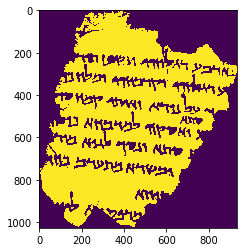

In [10]:
plt.imshow(opening)

-45
-40
-35
-30
-25
-20
-15
-10
-5
0
5
10
15
20
25
30
35
40
45
[ 189  331  508  735  951 1127 1268]
[ 205  465  606  751  892 1036 1267]
[ 209  462  609  781 1022 1274]
[ 207  360  595  779  915 1068 1264]
[ 204  358  586  745  880 1035 1246]
[ 286  480  692  872 1011 1218]
[ 138  273  443  578  769  893 1021 1181]
[  93  271  455  578  780  976 1134]
[  46  166  335  449  561  731  870 1078]
[ 107  284  393  497  688  842 1020]
[  27  168  389  510  677  862 1058]
[  48  250  372  517  718  900 1085]
[  72  214  350  491  615  748  912 1104]
[  89  222  375  505  683  822  953 1114]
[ 109  256  403  573  722  929 1116]
[ 126  270  438  574  719  918 1109]
[ 143  299  454  661  802  944 1092]
[ 157  299  454  670  831 1073]
[ 169  313  464  687  869 1056]


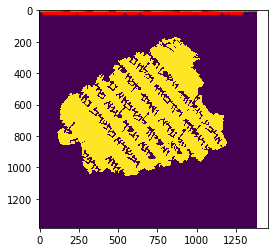

In [37]:
def getHist(inputimg):    
    if np.amax(inputimg) == 255:
        binary_img = inputimg[inputimg > 0] = 1
    else:
        binary_img = inputimg    
    height, width = binary_img.shape
    hist = []
    for x in range(height):
        # find indexes of start and end of paper
        pixels = np.where(binary_img[x] == 1)
        if len(pixels[0])>0:
            rightp = pixels[0][-1]
            leftp = pixels[0][0]
            #calculate paper width
            paperw = rightp-leftp
            #sum number of white pixels
            rowsum = binary_img[x].sum()
            normsum = rowsum/paperw
            #if normsum > 1.1: normsum = 0
            hist.append(normsum)
        else:
            hist.append(0)
    return hist

i = 0
hists = []
for angle in np.arange(-45,50,5):
    rotated = imutils.rotate_bound(crop_img, angle)
    opening = cv2.morphologyEx(rotated,cv2.MORPH_OPEN,kernel, iterations = 2)
    hist = opening[opening > 0] = 1  
    hists.append(getHist(opening))
    i += 1
    print(angle)
plt.imshow(opening)

for j in range(i):
    hist = hists[j]
    #plt.bar(range(1,1+len(hist)),hist)
    plt.plot(range(1,1+len(hist)),hist)
    peaks, _ = find_peaks(hist, height = sum(hist)/len(hist), distance = len(hist)/10)
   # plt.plot(hist.index[peaks], hist.water_level[hist], 'ro', label = 'positive peaks')
    print(peaks)
   # print(hist[list(peaks)])
    peakplot = [hist[i] for i in peaks]
    plt.plot(peaks,peakplot,'ro')
    #print (peakplot)

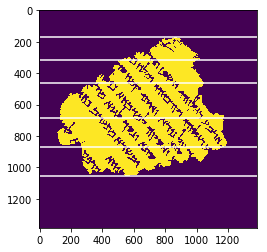

In [35]:
plt.imshow(opening)
plt.hlines(peaks,0,len(opening[0])-1,colors='w')

In [ ]:
# slices papyrus in little papyri
def sliceImg(inputimg, slices):
    if np.amax(inputimg) == 1:
        paper = inputimg[inputimg > 0] = 255
    else:
        paper = inputimg
    lastslice = 0
    height, width = paper.shape
    for y in range(len(slices)):
        #check if slice is big enough
        if slices[y]-lastslice > height/(len(slices)*2):
            cv2.imwrite('output_files/slice'+str(y)+'.png',paper[lastslice:slices[y]])
            lastslice = slices[y]
sliceImg(opening,peaks)